# Movie Classification

Oftentimes, we arbitrarily categorize things based on a general vibe. Is there anything more substantial to the subdivisions of movie eras beyond a general aesthetic? Can we reliably distinguish the eras of movie making based solely on the posters or movie stills? I want to explore the aesthetics of different movie eras while learning new tools like PyTorch and Python Image Library for image classification and exploration. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# used to convert genre id to name
import ast
import requests
from dotenv import load_dotenv

<h2><u>Data Exploration</u></h2>

<h3>Metadata</h3>

In [28]:
df = pd.read_csv('./data/metadata.csv')
df.head()

,filename,title,release_year,genres
0,15.jpg,Citizen Kane,1941,"[9648, 18]"
1,16442.jpg,Sergeant York,1941,"[10752, 18]"
2,43266.jpg,How Green Was My Valley,1941,[18]
3,11462.jpg,Suspicion,1941,"[9648, 10749, 53]"
4,29884.jpg,Ball of Fire,1941,"[35, 10749, 80]"


In [29]:
# should be no invalid data because of the way we pulled it, but checking anyway
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6050 entries, 0 to 6049
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      6050 non-null   object
 1   title         6050 non-null   object
 2   release_year  6050 non-null   int64 
 3   genres        6050 non-null   object
dtypes: int64(1), object(3)
memory usage: 189.2+ KB


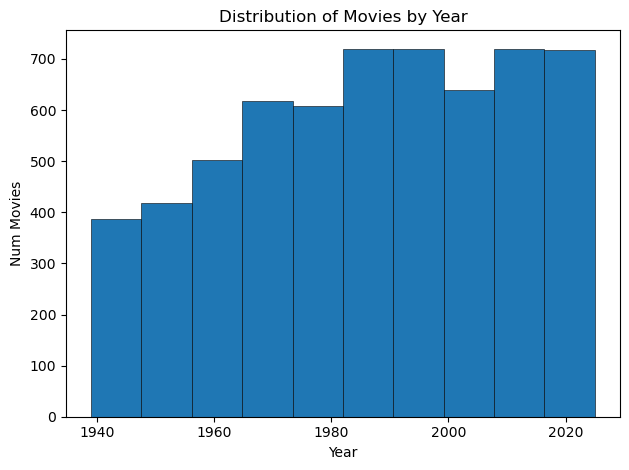

In [30]:
plt.hist(df['release_year'], edgecolor='black', linewidth=0.4)
plt.title("Distribution of Movies by Year")
plt.xlabel("Year")
plt.ylabel("Num Movies")
plt.tight_layout()
plt.show()

Kind of as expected, TMDB has much better capabilities for more recent and popular years, and some earlier years will have substantially less movies than later ones. We will try to account for this in our era subdivisions, but overall, we should be ok.

In [31]:
# Let's also make sure each entry in the csv has a corresponding image
res = []
for filename in df['filename']:
    if not os.path.exists(os.path.join("/Users/anubis/Desktop/Personal_Projects/movie-decade-classification/data/posters/", filename)):
        res.append(filename)
res

[]

##### Defining Film Eras:
Please check the <a href='https://github.com/Anubis-vc/movie-era-classification/blob/main/README.md'>README</a> for an in-depth discussion on how I chose these eras. As a reminder, I've attached the eras below:

1. *The Golden Age of Hollywood (1939 - 1949)*

2. *Post-War to New Hollywood Transition (1950 - 1966)*

3. *New Hollywood (1967 - 1982)*

4. *Blockbuster Era (1983 - 1994)*

5. *Indie and Digital Era (1995 - 2006)*

6. *Streaming and Superhero Era (2007 - 2017)*

7. *Modern Era/Post-Streaming (2018 - Current)* 

In [32]:
def find_era(year: int) -> str:
    if year < 1950:
        return "Golden Age"
    elif year < 1967:
        return "Post-War Transition"
    elif year < 1983:
        return "New Hollywood"
    elif year < 1995:
        return "Blockbuster Era"
    elif year < 2007:
        return "Digital Era"
    elif year < 2018:
        return "Franchise Era"
    else:
        return "Current Era"
    
df['temp'] = df['release_year'].apply(lambda x: find_era(x))
df['temp']

0        Golden Age
1        Golden Age
2        Golden Age
3        Golden Age
4        Golden Age
           ...     
6045    Current Era
6046    Current Era
6047    Current Era
6048    Current Era
6049    Current Era
Name: temp, Length: 6050, dtype: object

Though our dataset is small, it's good practice to vectorize data transformations for efficiency. I'm going to use the numpy select function though there is probably a way to do this in pure pandas I am unfamiliar with.

In [33]:
# clean up previous step
df.drop(columns=['temp'], inplace=True)

conditions = [
	df['release_year'] < 1950,
    df['release_year'] < 1967,
	df['release_year']< 1983,
 	df['release_year']< 1995,
    df['release_year']<  2007,
    df['release_year']< 2018
]

eras = ["Golden Age", "Post-War Transition", "New Hollywood", "Blockbuster Era", "Digital Era", "Franchise Era"]

df['era'] = np.select(conditions, eras, default="Current Era")
df


,filename,title,release_year,genres,era
0,15.jpg,Citizen Kane,1941,"[9648, 18]",Golden Age
1,16442.jpg,Sergeant York,1941,"[10752, 18]",Golden Age
2,43266.jpg,How Green Was My Valley,1941,[18],Golden Age
3,11462.jpg,Suspicion,1941,"[9648, 10749, 53]",Golden Age
4,29884.jpg,Ball of Fire,1941,"[35, 10749, 80]",Golden Age
...,...,...,...,...,...
6045,1077295.jpg,Godspeed,2023,[35],Current Era
6046,1012837.jpg,Born to Fly,2023,"[28, 18]",Current Era
6047,1155257.jpg,Last Suspect,2023,"[80, 9648, 18]",Current Era
6048,758323.jpg,The Pope's Exorcist,2023,"[27, 53]",Current Era


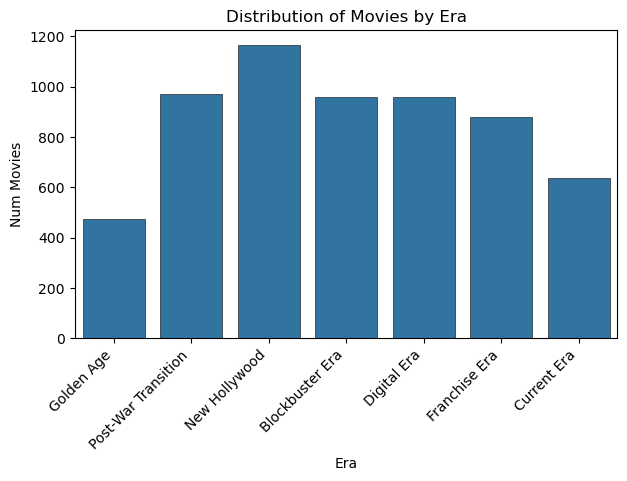

In [34]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x='era', edgecolor='black', linewidth=0.4)
plt.title("Distribution of Movies by Era")
plt.xlabel("Era")
plt.ylabel("Num Movies")
plt.xticks(rotation=45, ha='right')
plt.show()

In [35]:
era_to_int = {
    "Golden Age": 0,
    "Post-War Transition": 1,
    "New Hollywood": 2,
    "Blockbuster Era": 3,
    "Digital Era": 4,
    "Franchise Era": 5,
    "Current Era": 6
}

df['era_label'] = df['era'].map(era_to_int)
df

,filename,title,release_year,genres,era,era_label
0,15.jpg,Citizen Kane,1941,"[9648, 18]",Golden Age,0
1,16442.jpg,Sergeant York,1941,"[10752, 18]",Golden Age,0
2,43266.jpg,How Green Was My Valley,1941,[18],Golden Age,0
3,11462.jpg,Suspicion,1941,"[9648, 10749, 53]",Golden Age,0
4,29884.jpg,Ball of Fire,1941,"[35, 10749, 80]",Golden Age,0
...,...,...,...,...,...,...
6045,1077295.jpg,Godspeed,2023,[35],Current Era,6
6046,1012837.jpg,Born to Fly,2023,"[28, 18]",Current Era,6
6047,1155257.jpg,Last Suspect,2023,"[80, 9648, 18]",Current Era,6
6048,758323.jpg,The Pope's Exorcist,2023,"[27, 53]",Current Era,6


In [36]:
# let's check for duplicate titles in case
df.sort_values(by='release_year')
duplicated = df.duplicated(subset=['title'])
print(np.sum(duplicated))

# by default, grabbing the latest duplicate title
latest_dups = df[duplicated]
latest_dups

154


,filename,title,release_year,genres,era,era_label
392,223.jpg,Rebecca,1940,"[9648, 10749, 53]",Golden Age,0
476,1426701.jpg,USSR Air Fleet Day,1949,[99],Golden Age,0
577,1426786.jpg,USSR Air Fleet Day,1951,[99],Post-War Transition,1
757,787118.jpg,Rope,1947,[],Golden Age,0
920,1484868.jpg,To Catch a Thief,1958,"[18, 80]",Post-War Transition,1
...,...,...,...,...,...,...
5834,541671.jpg,Ballerina,2025,"[28, 53, 80]",Current Era,6
5840,1087891.jpg,The Amateur,2025,"[53, 28]",Current Era,6
5944,673593.jpg,Mean Girls,2024,[35],Current Era,6
5962,1084736.jpg,The Count of Monte Cristo,2024,"[12, 28, 18]",Current Era,6


It seems like these duplicates come from remakes sharing the same name. We can check this easily by taking a subset of title and year instead. Just for fun, let's also see when most of these remakes are from.

In [37]:
np.sum(df.duplicated(subset=['title', 'release_year']))

0

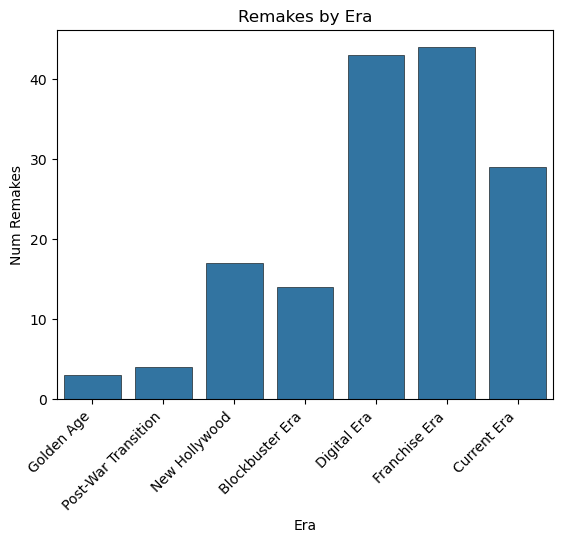

In [38]:
sns.countplot(data=latest_dups, x='era', edgecolor='black', linewidth=0.4)
plt.title("Remakes by Era")
plt.xlabel("Era")
plt.ylabel("Num Remakes")
plt.xticks(rotation=45, ha='right')
plt.show()

In [39]:
# since total counts are different, let's find proportions instead
era_order = df['era'].drop_duplicates().tolist()
era_counts = df['era'].value_counts().reindex(era_order)
remake_counts = latest_dups['era'].value_counts().reindex(era_order)

proportions = (remake_counts / era_counts)
proportions

era
Golden Age             0.006316
Post-War Transition    0.004115
New Hollywood          0.014580
Blockbuster Era        0.014583
Digital Era            0.044792
Franchise Era          0.050057
Current Era            0.045455
Name: count, dtype: float64

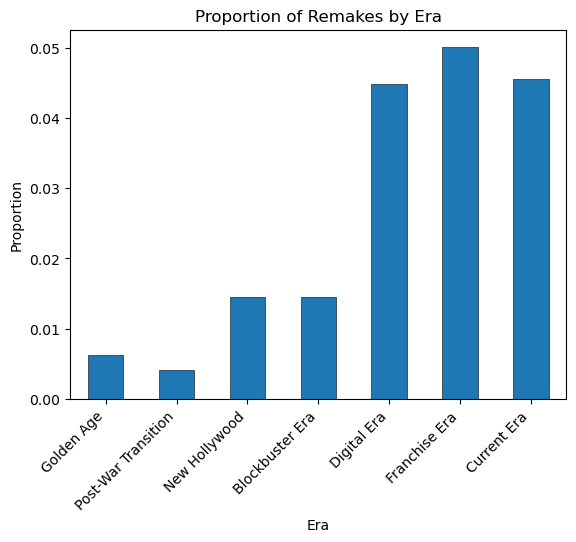

In [40]:
proportions.plot(kind='bar',
                 edgecolor='black',
                 linewidth=0.4,
                 xlabel='Era',
                 ylabel='Proportion',
                 title='Proportion of Remakes by Era')
plt.xticks(rotation=45, ha='right')
plt.show()

So clearly, the prevalence of remakes is something recent which does make sense: you have to have something to remake before you can remake it. That concludes some preliminary transformation of the metadata.

### Genres

Each movie currently contains a genre array with the multiclass classification of genre data from the TMDB API. As it stands, these labels mean nothing to anyone. Let's fix that and then explore the genre data.

In [41]:
df['genres'].dtype

dtype('O')

Pandas thinks the genre field is one big object because of the way our CSV Dictwriter converts the arrays to strings when it dumps them into the CSV. We can use the abstract syntax tree Python module to try and remedy this

In [ ]:
# convert string reps to lists
df['genres'] = df['genres'].apply(ast.literal_eval)

object


In [47]:
# count emptys
empty_count = (df['genres'].str.len() == 0).sum()
print(empty_count)

empty_rows = df[df['genres'].apply(lambda x: len(x) == 0)]
empty_rows

286


,filename,title,release_year,genres,era,era_label
19,1511764.jpg,Pardesi,1941,[],Golden Age,0
20,1511744.jpg,Shadi,1941,[],Golden Age,0
21,1510227.jpg,Nai Roshni,1941,[],Golden Age,0
23,1508601.jpg,Anjan,1941,[],Golden Age,0
25,1505376.jpg,The Lost Sheep,1941,[],Golden Age,0
...,...,...,...,...,...,...
1999,1506974.jpg,Cadoudal,1974,[],New Hollywood,2
2062,1267683.jpg,Protest,1976,[],New Hollywood,2
2212,1506547.jpg,The Hardy Boys and Nancy Drew Meet Dracula (Pa...,1977,[],New Hollywood,2
4476,565916.jpg,The Visual Effects of 'Scary Movie 4',2006,[],Digital Era,4


In [ ]:
remove_empty_genres = df[df['genres'].str.len() > 0]

# this df will only be used for genre processing, so i will drop the extra era data
remove_empty_genres = remove_empty_genres.drop(columns=['era', 'era_label'])
remove_empty_genres

,filename,title,release_year,genres
0,15.jpg,Citizen Kane,1941,"[9648, 18]"
1,16442.jpg,Sergeant York,1941,"[10752, 18]"
2,43266.jpg,How Green Was My Valley,1941,[18]
3,11462.jpg,Suspicion,1941,"[9648, 10749, 53]"
4,29884.jpg,Ball of Fire,1941,"[35, 10749, 80]"
...,...,...,...,...
6045,1077295.jpg,Godspeed,2023,[35]
6046,1012837.jpg,Born to Fly,2023,"[28, 18]"
6047,1155257.jpg,Last Suspect,2023,"[80, 9648, 18]"
6048,758323.jpg,The Pope's Exorcist,2023,"[27, 53]"


In [53]:
load_dotenv()

def get_genre_mapping():
    url = "https://api.themoviedb.org/3/genre/movie/list?language=en"
    params = { "api_key": os.getenv("TMDB_API_KEY") }
    response = requests.get(url, params)
    
    if response.status_code == 200:
        genres = response.json().get('genres')
        return { genre['id']: genre['name'] for genre in genres }
    else:
        print(f"Failed to fetch genres: {response.status_code}")
        return {}

In [54]:
genre_mapping = get_genre_mapping()
print(genre_mapping)

{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


In [65]:
def genre_to_name(ids, map):
    return [map.get(genre_id) for genre_id in ids]
    
remove_empty_genres['genre_labels'] = remove_empty_genres['genres'].apply(lambda x: genre_to_name(x, genre_mapping))
remove_empty_genres

,filename,title,release_year,genres,genre_labels
0,15.jpg,Citizen Kane,1941,"[9648, 18]","[Mystery, Drama]"
1,16442.jpg,Sergeant York,1941,"[10752, 18]","[War, Drama]"
2,43266.jpg,How Green Was My Valley,1941,[18],[Drama]
3,11462.jpg,Suspicion,1941,"[9648, 10749, 53]","[Mystery, Romance, Thriller]"
4,29884.jpg,Ball of Fire,1941,"[35, 10749, 80]","[Comedy, Romance, Crime]"
...,...,...,...,...,...
6045,1077295.jpg,Godspeed,2023,[35],[Comedy]
6046,1012837.jpg,Born to Fly,2023,"[28, 18]","[Action, Drama]"
6047,1155257.jpg,Last Suspect,2023,"[80, 9648, 18]","[Crime, Mystery, Drama]"
6048,758323.jpg,The Pope's Exorcist,2023,"[27, 53]","[Horror, Thriller]"


In [70]:
exploded = remove_empty_genres.explode('genre_labels')
dummies = pd.get_dummies(exploded['genre_labels'])
dummies_agrregated = dummies.groupby(exploded.index).sum()
genre_final = pd.concat([remove_empty_genres, dummies_agrregated], axis=1)
genre_final

,filename,title,release_year,genres,genre_labels,Action,Adventure,Animation,Comedy,Crime,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,15.jpg,Citizen Kane,1941,"[9648, 18]","[Mystery, Drama]",0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,16442.jpg,Sergeant York,1941,"[10752, 18]","[War, Drama]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,43266.jpg,How Green Was My Valley,1941,[18],[Drama],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11462.jpg,Suspicion,1941,"[9648, 10749, 53]","[Mystery, Romance, Thriller]",0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,29884.jpg,Ball of Fire,1941,"[35, 10749, 80]","[Comedy, Romance, Crime]",0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,1077295.jpg,Godspeed,2023,[35],[Comedy],0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6046,1012837.jpg,Born to Fly,2023,"[28, 18]","[Action, Drama]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6047,1155257.jpg,Last Suspect,2023,"[80, 9648, 18]","[Crime, Mystery, Drama]",0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
6048,758323.jpg,The Pope's Exorcist,2023,"[27, 53]","[Horror, Thriller]",0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


<h3>Images</h3>